<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/Train_CNN_Jan2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying cosmic ray transport from gas density slices

## Background:
While much has been learned about cosmic rays since their discovery in 1912, their bulk propagation and impact on normal gas are still uncertain. From plasma physics-based theory, we expect that the majority of cosmic rays are confined to hydrodmagnetic waves that they generate excite themselves through a non-resonant streaming instability -- we refer to this propagation as "streaming", in which case, to zeroth order, cosmic rays flow along magnetic field lines at the "Alfven speed". However, this theoretical picture also allows for "diffusive" cosmic ray transport, and the true mixture of streaming vs diffusive transport is not well-constrained despite enormous efforts to parse through multi-wavelength and multi-messsenger observations probing cosmic ray interactions with gas. Rather than create mock observables of these indicators, e.g. gamma-ray emission, this project seeks to use gas density images (for which we have an abundance of observational data) as the sole input to learn about cosmic ray transport.

The root of this idea lies in Bustard and Oh 2023, which showed that gas density statistics (predominantly, the power spectrum of gas density) can contain distinct imprints of streaming vs diffusive transport. Namely, with a dependence on transport mode, cosmic rays can damp turbulent fluctuations, causing a dearth of small-scale structure and unique changes to canonical turbulent power spectra.

Unfortunately, there are some degeneracies: depending on how magnetized the plasma is, streaming cosmic rays can leave similar imprints to diffusing cosmic rays. *We wonder, then, if there are other learnable imprints on gas density slices that can help disentangle these transport modes. Cue convolutional neural networks (CNNs)!*

## Methods
We'll train a multi-layer CNN on gas density images generated from simulations of stirred turbulence in a composite mixture of gas, magnetic fields, and cosmic rays. The initial pressures of gas and cosmic rays are equal, which is reasonable for the interstellar medium of Milky Way like galaxies and possibly for surrounding "circumgalactic" media in the outskirts of galaxies.

There are ~8000 training images per class, where the classes are
1. No cosmic rays
2. Cosmic ray advection -- cosmic rays are locked to the gas and neither diffuse nor stream
3. Cosmic ray diffusion with a small diffusivity
4. Cosmic ray diffusion with a large diffusivity
5. Cosmic ray streaming (plus a small diffusivity)


## Code details
Much of the code that underpins this study is imported into this notebook and available on Github: https://github.com/bustardchad/ML_Turb. This includes helper functions that e.g. load and preprocess the images (load_data), set up the fitting procedure for the network (classify_setup), and plot metrics and interpret the outcome with saliency maps, occlusion maps, etc. (interpet_CNN)


## Data details
More info on the simulation setup can be found in Bustard and Oh 2023 (https://arxiv.org/pdf/2301.04156.pdf) and in our in-prep paper (Bustard and Wu 2023, link to follow)

The data_creation folder on Github (https://github.com/bustardchad/ML_Turb/tree/main/data_creation) contains scripts that helped cut up the simulation data cubes into normalized, augmented image sets. There are multiple possible sets of images to load in here, determined by the following:

-- Full_Power = Normal gas density images

-- Kill_Power = Images where the power spectra have been flattened; this is an interesting test case to see if a network can learn more than just spectral information imprinted by the cosmic rays.

-- "small" or "large" = size of the datasets. For "large", all images are loaded in. For "small", only a random 1/4th of the images are loaded in.


load_data.py is responsible for loading the correct data given parameters set in the config dataclass



## Import packages


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset
import os

import seaborn as sn
import pandas as pd

!pip install cmasher
!pip install torchmetrics

!pip install torchinfo
!pip install tensorboard
from torchinfo import summary

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.5/531.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.8 MB/s eta 0:00:00


'cuda'

## Configuration for training

This is where we set the simulation type, files to consider, etc. To run the default classification model using small dataset sizes for each cosmic ray transport class, use

```
class TrainingConfig:
    sim_type = 'classify'
    data_presplit = True # whether data has already been split into training, val, test
    fileDirArr = ['MHD_beta10', 'CR_Advect_beta10', 'CR_Diff_Fiducial_beta10', 'CR_Diff100_beta10', 'CR_withStreaming_beta10']
    field_list = ['density']
    projection_depth = 1
    killPwr = False
    num_classes = 5
    train_frac = 0.6
    batch_size = 64
    use_transforms = False # add horizontal and vertical flipped versions
    epochs = 25
    stop_early = True
    patience = 5
    run_locally = False # if running on my computer, take files from local directory instead of downloading them
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Small/Full_Power/'
    dataset_size = 'small'
    hold_out_test_set = True
    save_dir = 'runs/'
    run_name = 'MHD_CRTransport_FullPwr_allClasses_multiple_snapshots_small'

config = TrainingConfig()
```

In [ ]:
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'classify'
    inference = False
    data_presplit = True # whether data has already been split into training, val, test
    fileDirArr = ['MHD_beta10_projection', 'CR_Advect_beta10_projection', 'CR_Diff_Fiducial_beta10_projection', 'CR_Diff100_beta10_projection', 'CR_withStreaming_beta10_projection']
    #fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    projection_depth = 1
    killPwr = True
    num_classes = 5
    train_frac = 0.6
    batch_size = 64
    use_transforms = True # create horizontal and vertical flipped versions
    augment_with_transforms = False
    flip_prob = 0.5
    data_sample_fraction = 0.5
    epochs = 25
    stop_early = True
    patience = 5
    run_locally = True # if running on my computer, take files from local directory instead of downloading them
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Large/Kill_Power/'
    dataset_size = 'small'
    hold_out_test_set = True
    save_dir = 'runs/'
    run_name = 'MHD_CRTransport_KillPwr_allClasses_multiple_snapshots_large'

config = TrainingConfig()

The following cell will either mount Google Drive or download data from Google Drive links. If running this on Colab and NOT the author of this notebook, make sure to set

 run_locally = False

 in the config dataclass above

In [ ]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown

from google.colab import drive


if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
else: # Access files on google drive directly
    drive.mount('/content/drive')

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Mounted at /content/drive


In [ ]:
# If on Google Colab, need to clone repo to have access to helper files

!git clone https://github.com/bustardchad/ML_Turb
!pip install memory-profiler

import ML_Turb.utilities.load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp
import ML_Turb.utilities.classify_setup as classify_setup

# load data
#train_dl, valid_dl, test_dl = load_data.preprocess(config)

Cloning into 'ML_Turb'...
remote: Enumerating objects: 480, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 480 (delta 23), reused 17 (delta 8), pack-reused 440
Receiving objects: 100% (480/480), 83.82 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (256/256), done.


## Set up and train the model

First, we create the network architecture, which consists of multiple convolutional layers (each with batch normalization, dropout, and SiLu activations), followed by average pooling and a fully connected layer to predict the class. Predictions with the highest probability are chosen as the predicted class.

As this is a classification task, we minimize the cross-entropy loss.

For gradient descent, we use AdamW.

In [ ]:
from torchmetrics import MetricCollection, MetricTracker, Accuracy, Precision, Recall
from torch.utils.tensorboard import SummaryWriter

# create a CNN using the built-in Sequential class
def create_model(config, p_drop = 0.25, lr = 1.e-3, weight_decay = 1.e-4):


  # model = nn.Sequential(
  #     nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(8),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(16),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(32),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(64),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.AdaptiveAvgPool2d(4), # works with any input size
  #     nn.Flatten(),
  #     nn.Linear(64*4*4,config.num_classes)
  # ).to(device)

  # model = nn.Sequential(
  #     nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(8),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(16),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(32),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     nn.AdaptiveAvgPool2d(4), # works with any input size
  #     nn.Flatten(),
  #     nn.Linear(32*4*4,config.num_classes)
  # ).to(device)

  # model = nn.Sequential(
  #     nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
  #     nn.BatchNorm2d(8),
  #     nn.SiLU(),
  #     nn.Dropout(p_drop),
  #     # nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
  #     # nn.BatchNorm2d(16),
  #     # nn.SiLU(),
  #     # nn.Dropout(p_drop),
  #     # nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
  #     # nn.BatchNorm2d(32),
  #     # nn.SiLU(),
  #     # nn.Dropout(p_drop),
  #     nn.AdaptiveAvgPool2d(4), # works with any input size
  #     nn.Flatten(),
  #     nn.Linear(8*4*4,config.num_classes)
  # ).to(device)


  model = nn.Sequential(
      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(8),
      nn.SiLU(),
      nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(16),
      nn.SiLU(),
      nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.SiLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.SiLU(),
      # nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
      # nn.BatchNorm2d(128),
      # nn.SiLU(),
      nn.AdaptiveAvgPool2d(4), # works with any input size
      nn.Dropout(p_drop), ### MAYBE ADD DROPOUT HERE? ALSO TRY WITHOUT.
      nn.Flatten(),
      nn.Linear(64*4*4,config.num_classes)
  ).to(device)

  # create a loss function and optimizer

  loss_fn = nn.CrossEntropyLoss(weight = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device))

  opt = torch.optim.AdamW(model.parameters(),
                          lr = lr,
                          weight_decay = weight_decay)

  # what to track (in addition to training and validation loss)
  # use torchmetrics

  num_classes = config.num_classes
  metric_collection = MetricCollection({
      'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
      'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
      'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
  })

  metric_collection_val = metric_collection

  tracker_train = MetricTracker(metric_collection)
  tracker_val = MetricTracker(metric_collection_val)


  return model, loss_fn, opt, tracker_train, tracker_val

Loading training file /train_MHD_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Advect_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Diff_Fiducial_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_Diff100_beta10_projection_density_depth_1_small.npy for classification problem
Loading training file /train_CR_withStreaming_beta10_projection_density_depth_1_small.npy for classification problem


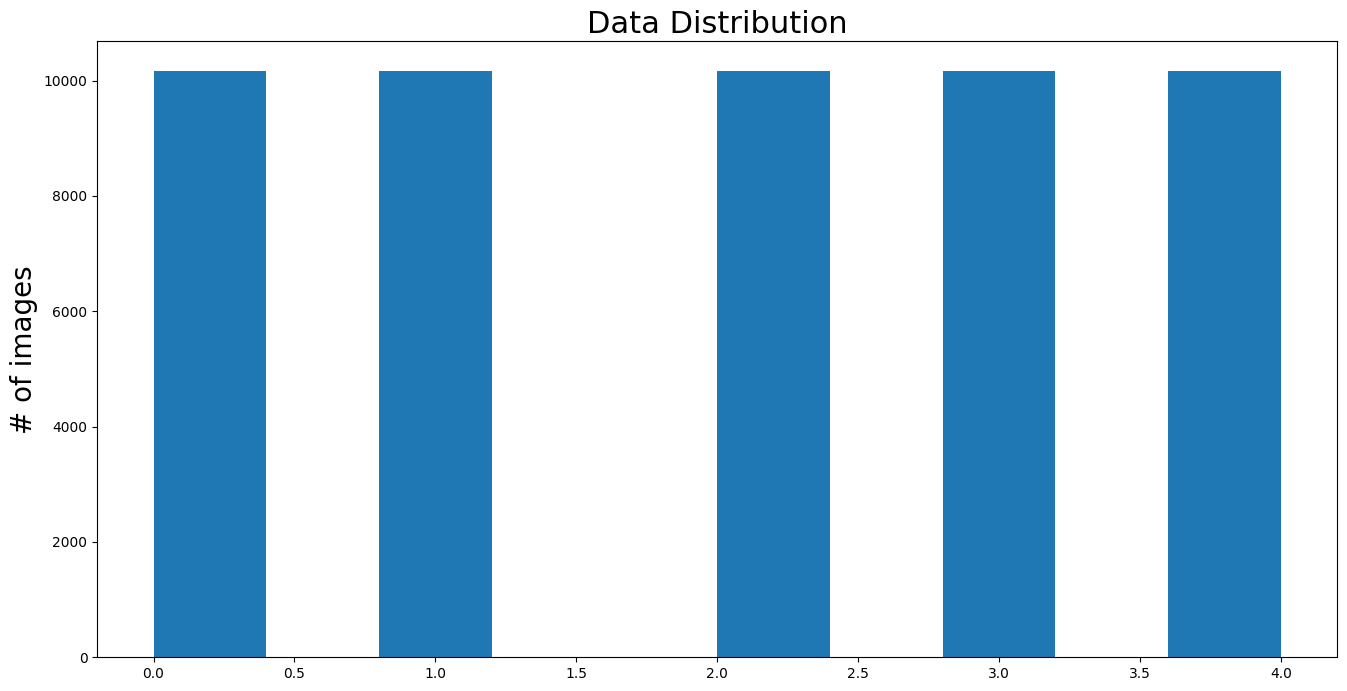

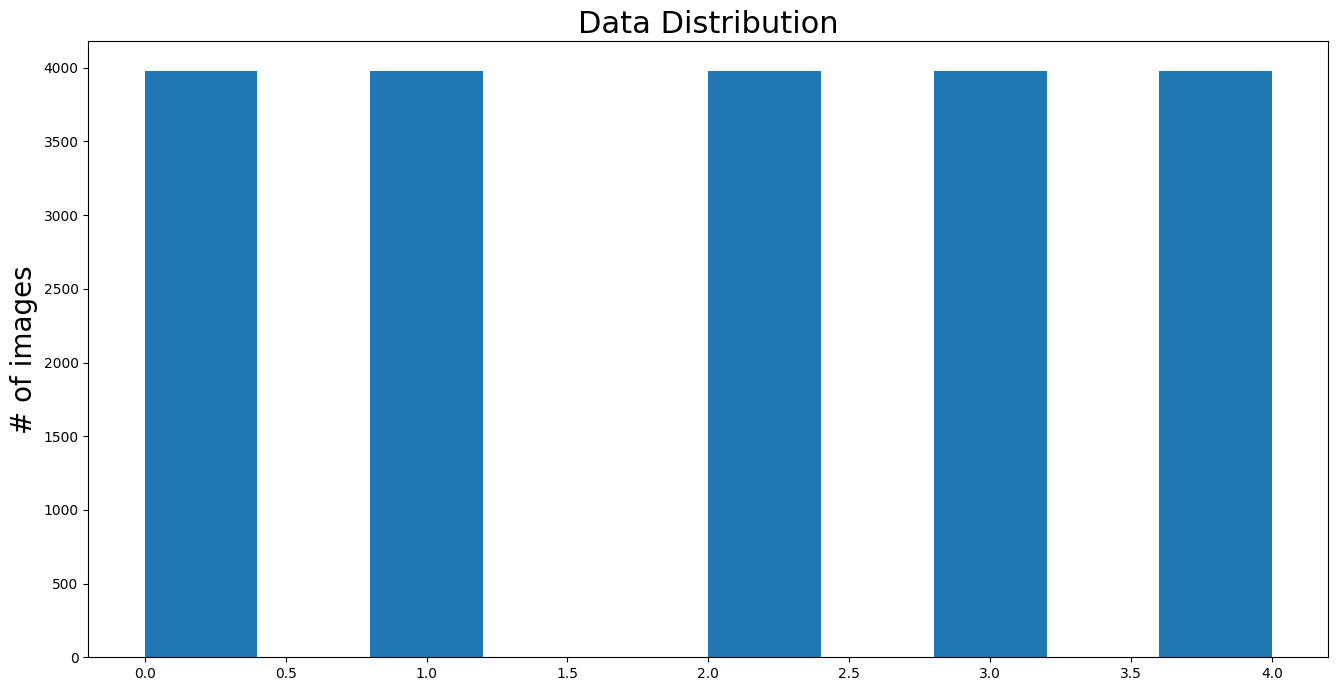

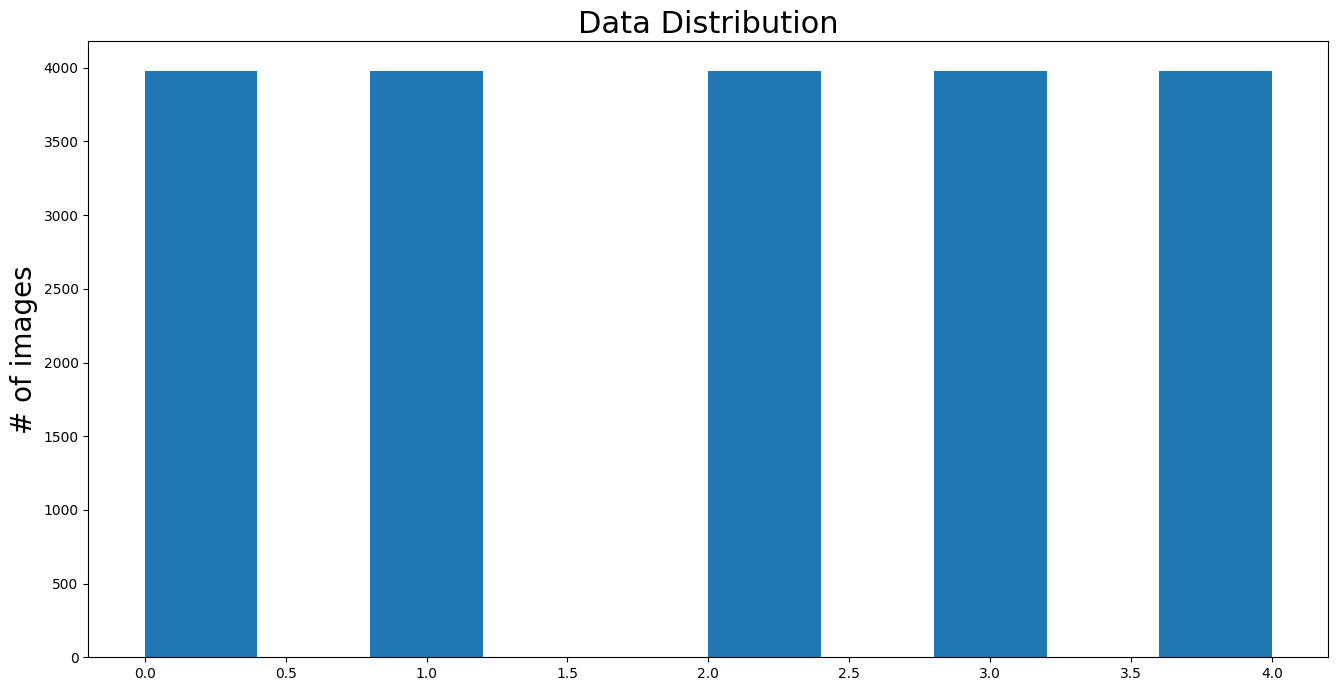

In [ ]:
# Load data
torch.cuda.empty_cache()

# TODO: Log and store metrics and associated checkpoint files in folders
# TODO: Create a composite figure showing losses for different hyperparams

save_dir = 'runs/'
config.save_dir = save_dir
!mkdir 'runs'

batch_size = 64
config.batch_size = batch_size


# load data (this needs to be done in-loop when batch_size changes)
train_dl, valid_dl, _ = load_data.preprocess(config)

Shown above are the image counts in training set (top figure), validation set (middle figure), and test set (bottom figure) for each class. E.g. for 5 classes and "small" datasets, there are 5 bars showing ~8,000 images per class in the training set and ~2,000 images per class in the validation and test sets.

## (Optional) Visualize network graph

In [ ]:
# Do a quick check of the model graph
# create the model
model, loss_fn, opt, tracker_train, tracker_val = create_model(config, 0.25, 5e-4, 1e-4)

images, labels = next(iter(train_dl))

writer = SummaryWriter("tensorboard_logs/")
writer.add_graph(model.cpu(), images)
writer.close()

StopIteration: ignored

In [ ]:
!cd tensorboard_logs
%load_ext tensorboard
%tensorboard --logdir tensorboard_logs

/bin/bash: line 1: cd: tensorboard_logs: No such file or directory


Launching TensorBoard...

KeyboardInterrupt: ignored

## Run the model!

Here, we'll loop over and tune some hyperparameters. For the full_power model, this works well right away with a learning rate of 1e-3, dropout fraction of 0.25, and weight decay of 1e-4. We reach an accuracy of 90% in under 10 epochs.

For the kill_power runs, overfitting is more of a concern, and we must be more careful to 1. decrease our model capacity, 2. increase regularization via larger dropout or larger weight decay.

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [64, 5]                   --
├─Conv2d: 1-1                            [64, 8, 64, 64]           80
├─BatchNorm2d: 1-2                       [64, 8, 64, 64]           16
├─SiLU: 1-3                              [64, 8, 64, 64]           --
├─Conv2d: 1-4                            [64, 16, 32, 32]          1,168
├─BatchNorm2d: 1-5                       [64, 16, 32, 32]          32
├─SiLU: 1-6                              [64, 16, 32, 32]          --
├─Conv2d: 1-7                            [64, 32, 16, 16]          4,640
├─BatchNorm2d: 1-8                       [64, 32, 16, 16]          64
├─SiLU: 1-9                              [64, 32, 16, 16]          --
├─Conv2d: 1-10                           [64, 64, 8, 8]            18,496
├─BatchNorm2d: 1-11                      [64, 64, 8, 8]            128
├─SiLU: 1-12                             [64, 64, 8, 8]            --
├─Ad

/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 0 | Train Loss: 0.86370| Validation loss: 0.62518


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 1 | Train Loss: 0.38260| Validation loss: 0.59924
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 2 | Train Loss: 0.30496| Validation loss: 0.29561
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 3 | Train Loss: 0.26194| Validation loss: 0.62411


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 4 | Train Loss: 0.23378| Validation loss: 0.40560
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 5 | Train Loss: 0.21412| Validation loss: 0.23452
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 6 | Train Loss: 0.19101| Validation loss: 0.20285
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 7 | Train Loss: 0.18107| Validation loss: 0.26126


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 8 | Train Loss: 0.16958| Validation loss: 0.39017


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 9 | Train Loss: 0.15958| Validation loss: 0.37578
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 10 | Train Loss: 0.15129| Validation loss: 0.35587
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 11 | Train Loss: 0.14447| Validation loss: 0.27737
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 12 | Train Loss: 0.13923| Validation loss: 0.18047
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 13 | Train Loss: 0.13524| Validation loss: 0.15665
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 14 | Train Loss: 0.13073| Validation loss: 0.21678


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 15 | Train Loss: 0.12453| Validation loss: 0.14321
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 16 | Train Loss: 0.12533| Validation loss: 0.18333


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 17 | Train Loss: 0.11899| Validation loss: 0.25383


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 18 | Train Loss: 0.11491| Validation loss: 0.30426


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 19 | Train Loss: 0.11228| Validation loss: 0.19099
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 20 | Train Loss: 0.10970| Validation loss: 0.12940
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 21 | Train Loss: 0.10864| Validation loss: 0.12580
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 22 | Train Loss: 0.10612| Validation loss: 0.18890


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 23 | Train Loss: 0.10705| Validation loss: 0.50300


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 24 | Train Loss: 0.10304| Validation loss: 0.15883
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 25 | Train Loss: 0.09917| Validation loss: 0.24417


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 26 | Train Loss: 0.09945| Validation loss: 0.15174
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 27 | Train Loss: 0.09881| Validation loss: 0.14462
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 28 | Train Loss: 0.09333| Validation loss: 0.17611


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 29 | Train Loss: 0.09193| Validation loss: 0.11099
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 30 | Train Loss: 0.09532| Validation loss: 0.13730


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 31 | Train Loss: 0.08886| Validation loss: 0.13670
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 32 | Train Loss: 0.08784| Validation loss: 0.24990


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 33 | Train Loss: 0.08878| Validation loss: 0.10738
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 34 | Train Loss: 0.08655| Validation loss: 0.13904


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 35 | Train Loss: 0.08337| Validation loss: 0.16606


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 36 | Train Loss: 0.08367| Validation loss: 0.11378
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 37 | Train Loss: 0.08135| Validation loss: 0.30782


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 38 | Train Loss: 0.08016| Validation loss: 0.12740
Saving model checkpoint


/content/ML_Turb/utilities/classify_setup.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2, ignore_index = True)


Epoch: 39 | Train Loss: 0.08121| Validation loss: 0.10170
Saving model checkpoint


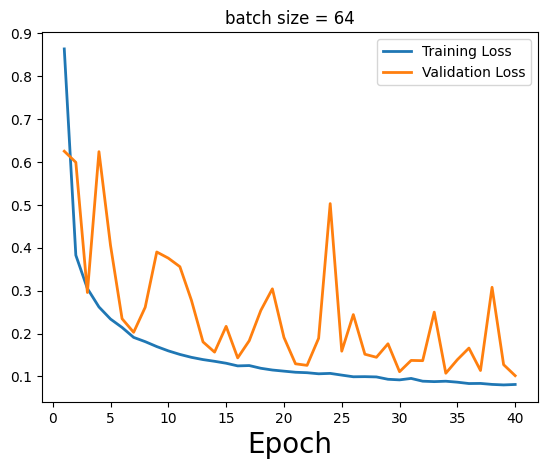

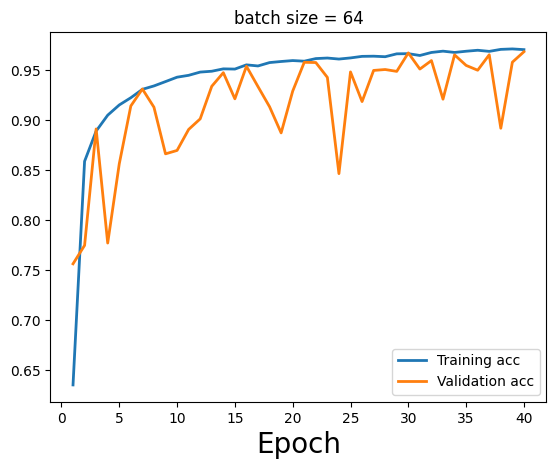

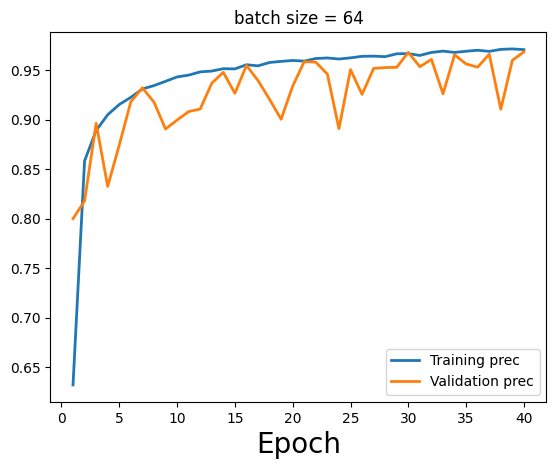

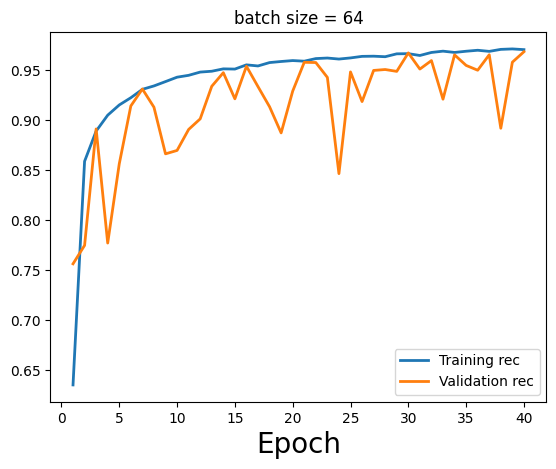

In [ ]:
p = 0.25
weight_decay = 1.e-4
# loop over different hyperparameters
for (lr, p, epochs) in [(5e-4, 0.35, 40)]:
# for (lr, p, epochs) in [(5e-4, 0.25, 40), (5e-4, 0.35, 40)]: # fiducial setting
  config.epochs = epochs
  run_name = 'fourlayercapacity_fixeddropout_killpwr_batch_size_'+str(batch_size)
  config.run_name = run_name+'lr_'+str(lr)+'_pdrop_'+str(p)+'_classweights1_moreepochs'


  # create the model
  model, loss_fn, opt, tracker_train, tracker_val = create_model(config, p, lr, weight_decay)

  # get summary of model
  print(summary(model.cpu(), (config.batch_size,1, 128, 128)))

  # run new model
  run_output = classify_setup.fit(config, model.to(device), loss_fn, opt, train_dl, valid_dl,
                   tracker_train, tracker_val)

  model_trained, loss_arr_train, loss_arr_val, tracker_train, tracker_val = run_output


  total_train_metrics = tracker_train.compute_all()
  total_val_metrics = tracker_val.compute_all()

  # plot loss
  classify_setup.plot_losses(config, loss_arr_train, loss_arr_val)

  # plot other metrics in met_list
  met_list = ['acc','prec','rec']
  classify_setup.plot_other_metrics(config, total_train_metrics, total_val_metrics, met_list)

  # model_trained.eval()
  # # create confusion matrix
  # fig = interp.confusion(config, model_trained.cpu(), valid_dl, normalize=None)
  # fig.savefig(config.save_dir+config.run_name+'_confusion.png',dpi=600)
  # fig.show()

  # # Dictionary of saliency plot params
  # saliency_plot_params = {"n_examples" : 6,
  #                         "n_classes" : 5,
  #                         "levels" : [0.6],
  #                         "figsize" : (16,16)}
  # # plot saliency maps
  # fig = interp.plot_saliency(config, model_trained.cpu(), valid_dl,
  #                            saliency_plot_params)
  # fig.savefig(config.save_dir+config.run_name+'_saliency.png',dpi=600)
  # fig.show()

  """
  # Dictionary of occlusion plot params
  occlusion_plot_params = {"n_examples" : 6,
                           "n_classes" : 5,
                           "labels" : [0,1,2,3,4],
                           "occ_size" : 32,
                           "occ_stride" : 32,
                           "occ_pixel" : 0.5,
                           "figsize" : (16,32)}
  """
  # quick occlusion experiment
  #fig = interp.plot_occlusion(config, model_trained.cpu(), valid_dl,
  #                            occlusion_plot_params)
  #fig.savefig(config.save_dir+config.run_name+'_occlusion.png',dpi=600)
  #fig.show()

In [ ]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

def create_lr_model(config, p_drop = 0.25, lr = 1.e-3, weight_decay = 1.e-4):

  model = nn.Sequential(
    nn.Linear(128*128,config.num_classes)
  ).to(device)
  # create a loss function and optimizer

  loss_fn = nn.CrossEntropyLoss(weight = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0]).to(device))

  opt = torch.optim.AdamW(model.parameters(),
                          lr = lr,
                          weight_decay = weight_decay)

  # what to track (in addition to training and validation loss)
  # use torchmetrics

  num_classes = config.num_classes
  metric_collection = MetricCollection({
      'acc': Accuracy(task='multiclass', num_classes=num_classes).to(device),
      'prec': Precision(task='multiclass',num_classes=num_classes, average='macro').to(device),
      'rec': Recall(task='multiclass',num_classes=num_classes, average='macro').to(device)
  })

  metric_collection_val = metric_collection

  tracker_train = MetricTracker(metric_collection)
  tracker_val = MetricTracker(metric_collection_val)


  return model, loss_fn, opt, tracker_train, tracker_val





In [ ]:
p = 0.25
weight_decay = 1.e-4
# loop over different hyperparameters
for (lr, p, epochs) in [(1e-3, 0.25, 40), (5e-4, 0.25, 40)]:
# for (lr, p, epochs) in [(5e-4, 0.25, 40), (5e-4, 0.35, 40)]: # fiducial setting
  config.epochs = epochs
  run_name = 'logisticregression_fullpwr_batch_size_'+str(batch_size)
  config.run_name = run_name+'lr_'+str(lr)+'_pdrop_'+str(p)+'_classweights1_moreepochs'


  # create the model
  model, loss_fn, opt, tracker_train, tracker_val = create_lr_model(config, p, lr, weight_decay)

  # get summary of model
  # print(summary(model.cpu(), (config.batch_size,1, 128, 128)))

  # run new model
  run_output = classify_setup.fit(config, model.to(device), loss_fn, opt, train_dl, valid_dl,
                   tracker_train, tracker_val)

  model_trained, loss_arr_train, loss_arr_val, tracker_train, tracker_val = run_output


  total_train_metrics = tracker_train.compute_all()
  total_val_metrics = tracker_val.compute_all()

  # plot loss
  classify_setup.plot_losses(config, loss_arr_train, loss_arr_val)

  # plot other metrics in met_list
  met_list = ['acc','prec','rec']
  classify_setup.plot_other_metrics(config, total_train_metrics, total_val_metrics, met_list)

RuntimeError: ignored

In [ ]:
!tar -czvf 'DropoutTestAndCapacityTest_FullPower_Jan2_2024.tar.gz' 'runs'

runs/
runs/fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.25_classweights1_moreepochs_Loss.png
runs/Loss_fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.5_classweights1_80epochs.csv
runs/fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.5_classweights1_moreepochs_prec.png
runs/fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.35_classweights1_moreepochs_prec.png
runs/fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.25_classweights1_moreepochs_rec.png
runs/fivelayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.35_classweights1_moreepochs_acc.png
runs/Loss_fourlayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.5_classweights1_moreepochs.csv
runs/threelayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.35_classweights1_moreepochs_acc.png
runs/Loss_fivelayercapacity_newdropout_fullpwr_batch_size_64lr_0.001_pdrop_0.35_classweights1_moreepochs.csv
runs/threelayercapac

## Further analysis


In [ ]:
# structure of the saved model

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)
"""

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(32*4*4,config.num_classes)
)

"""
# path to checkpoint file
path_to_chk = 'runs/'

# load the saved model checkpoint
model.load_state_dict(torch.load(path_to_chk + config.run_name + '_checkpoint.pt',map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=5, bias=Tr

Accuracy for class: MHD_beta10 is 92.3 %
Accuracy for class: CR_Diff_Fiducial_beta10 is 100.0 %


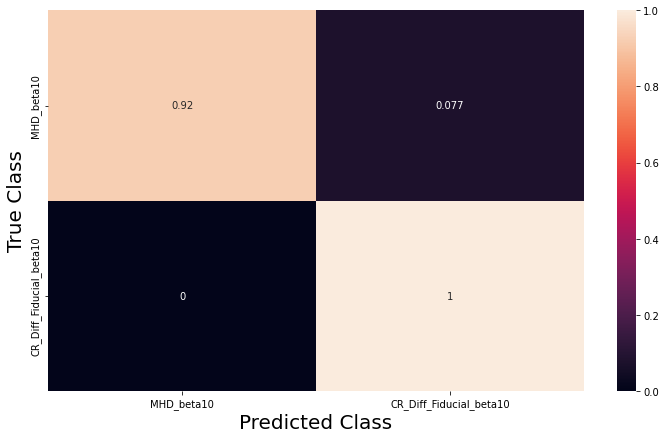

In [ ]:
# create confusion matrix
fig = interp.confusion(config, model, valid_dl)
fig.show()
#fig.savefig('Confusion_Validation_KillPwr_twoClasses.png',dpi=600)

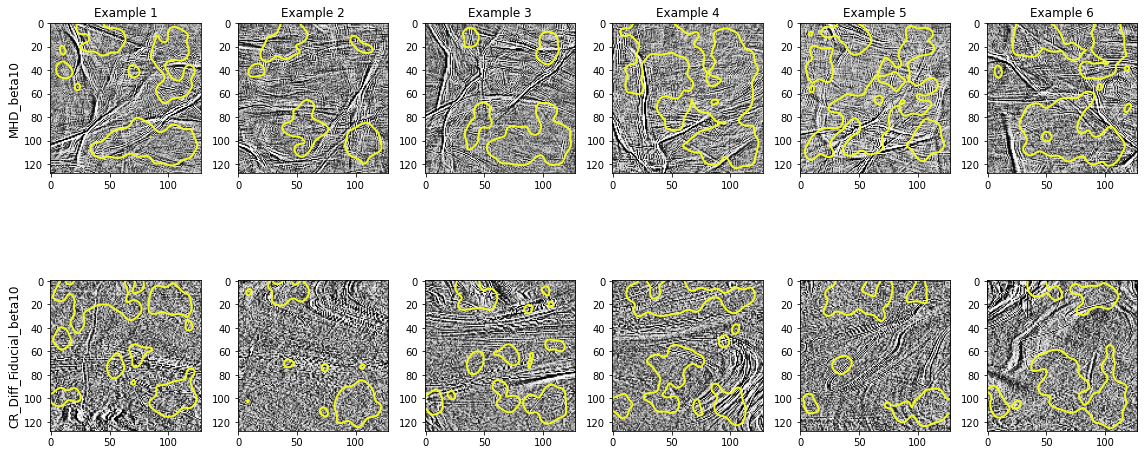

In [ ]:
# plot saliency maps
fig = interp.plot_saliency(config, model, valid_dl, n_examples = 6, n_classes = 2, levels = [0.6])
fig.show()
fig.savefig("Saliency_KillPwr_twoClasses.png",dpi=600)

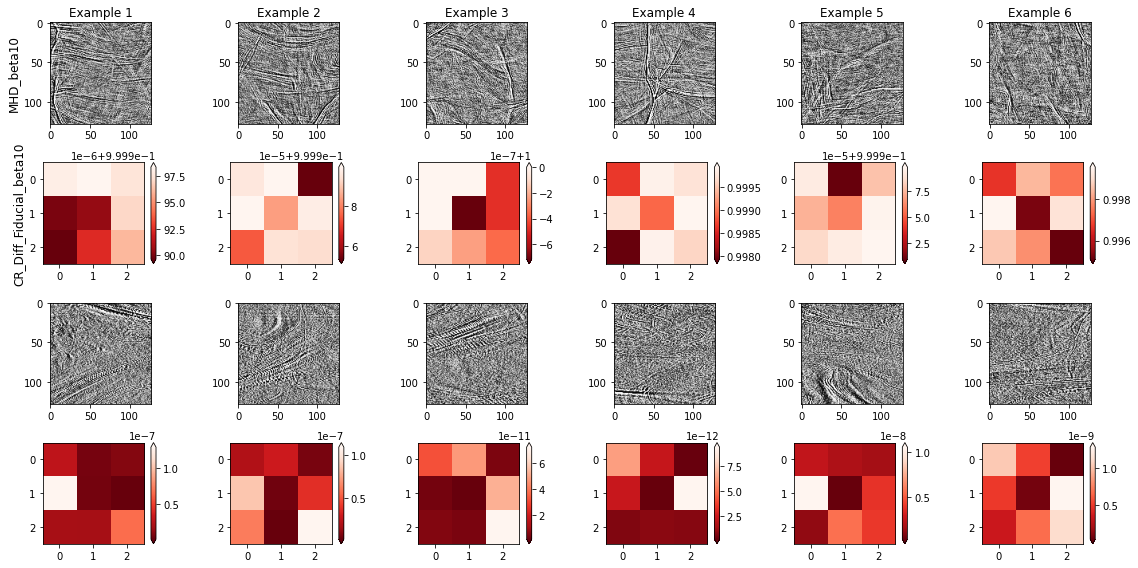

In [ ]:
# quick occlusion experiment
fig = interp.plot_occlusion(config, model, valid_dl, n_examples=6, n_classes=2,
                            label=0, occ_size=32, occ_stride=32, occ_pixel=0.5)
#fig.show()
fig.savefig('Occlusion_KillPwr_twoClasses.png',dpi=600)

## Further interpreting the network (Under construction)

In [ ]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=5220af80bcd5f87d96f5b81501cd44a03fe50afcffbc86d83911e532b07c381c
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [ ]:
# taken straight from this link for now: https://jacobgil.github.io/pytorch-gradcam-book/introduction.html

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
import cv2

#print(model.children)
#target
#target_layers = [model.children()[0]]
# how do you access layers from nn.Sequential??

target_layers = [model[-4]]

dataiter = iter(train_dl)
images, labels = next(dataiter)
img = images[0,:,:,:].numpy()
gray_img_float = np.float32(img) / 255

input_tensor = torch.from_numpy(gray_img_float).reshape(1,1,128,128)

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers = target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

#targets = [ClassifierOutputTarget(1)]
targets = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
#grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(gray_img_float, grayscale_cam[0,:], use_rgb=True)

ValueError: ignored

In [ ]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
# Create the metric target, often the confidence drop in a score of some category
metric_target = ClassifierOutputSoftmaxTarget(281)
scores, batch_visualizations = CamMultImageConfidenceChange()(input_tensor,
  inverse_cams, targets, model, return_visualization=True)
visualization = deprocess_image(batch_visualizations[0, :])

# State of the art metric: Remove and Debias
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst
cam_metric = ROADMostRelevantFirst(percentile=75)
scores, perturbation_visualizations = cam_metric(input_tensor,
  grayscale_cams, targets, model, return_visualization=True)

# You can also average accross different percentiles, and combine
# (LeastRelevantFirst - MostRelevantFirst) / 2
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirstAverage,
                                          ROADLeastRelevantFirstAverage,
                                          ROADCombined
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
scores = cam_metric(input_tensor, grayscale_cams, targets, model)